# Variational Autoencoder

You are tasked with developing a Variational Autoencoder (VAE) in Tensorflow and Keras. A Variational Autoencoder is a particular type of neural network, which uses Variational (or Bayesian) Inference to generate synthetic data. You have previously developed an Autoencoder in the tutorials. For this assignment, you will need to implement a custom loss function into your model, and a custom layer, which will be described. The notebook provided contains the basic structure of the model, which you will need to complete.

You should submit your completed notebook, with all outputs printed, to the canvas assignments page, along with a 1-page report that details how you compiled and trained the model, and a discussion of the reconstruction and generative results of the network.

In [ ]:
# Module imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
### Create an encoder model based on the autoencoder used in Tutorial 7.
### The model should have the following properties:
# Model: "encoder"
# _____________________________________________________________________________
#  Layer (type)                 Output Shape         Activation     Input      
# =============================================================================
#  enc_input (InputLayer)       [(None, 28, 28, 1)]  None           
#  enc_flatten (Flatten)        (None, 784)          None           enc_input
#  enc_dense_1 (Dense)          (None, 2000)         ReLU           enc_flatten
#  enc_dense_2 (Dense)          (None, 256)          ReLU           enc_dense_1
#  z_mean (Dense)               (None, 2)            None           enc_dense_2
#  z_log_var (Dense)            (None, 2)            None           enc_dense_2

enc_input = tf.keras.layers.Input( shape=( 28 , 28 , 1 ) , name='enc_input' )
enc_flatten = tf.keras.layers.Flatten( name='enc_flatten' )( enc_input )
enc_dense_1 = tf.keras.layers.Dense( 2000 , activation='relu' , name='enc_dense_1' )( enc_flatten )
enc_dense_2 = tf.keras.layers.Dense( 256 , activation='relu' , name='enc_dense_2' )( enc_dense_1 )
z_mean = tf.keras.layers.Dense( 2 , name='z_mean' )( enc_dense_2 )
z_log_var = tf.keras.layers.Dense( 2 , name='z_log_var' )( enc_dense_2 )

encoder = tf.keras.models.Model( enc_input , [ z_mean , z_log_var ] , name='encoder' )
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 enc_input (InputLayer)         [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 enc_flatten (Flatten)          (None, 784)          0           ['enc_input[0][0]']              
                                                                                                  
 enc_dense_1 (Dense)            (None, 2000)         1570000     ['enc_flatten[0][0]']            
                                                                                                  
 enc_dense_2 (Dense)            (None, 256)          512256      ['enc_dense_1[0][0]']            
                                                                                            

In [ ]:
### Create a decoder model with the following properties:
# Model: "decoder"
# _____________________________________________________________________________
#  Layer (type)                Output Shape          Activation     Input
# =============================================================================
#  dec_input (InputLayer)      [(None, 2)]           None
#  dec_dense_1 (Dense)         (None, 256)           ReLU           dec_input
#  dec_dense_2 (Dense)         (None, 2000)          ReLU           dec_dense_1
#  dec_dense_3 (Dense)         (None, 784)           Sigmoid        dec_dense_2
#  img_out (Reshape)           (None, 28, 28, 1)     None           des_dense_3

dec_input = tf.keras.layers.Input( shape=( 2 , ) , name='dec_input' )
dec_dense_1 = tf.keras.layers.Dense( 256 , activation='relu' , name='dec_dense_1' )( dec_input )
dec_dense_2 = tf.keras.layers.Dense( 2000 , activation='relu' , name='dec_dense_2' )( dec_dense_1 )
dec_dense_3 = tf.keras.layers.Dense( 784 , activation='sigmoid' , name='dec_dense_3' )( dec_dense_2 )
img_out = tf.keras.layers.Reshape( ( 28 , 28 , 1 ) )( dec_dense_3 )

decoder = tf.keras.models.Model( dec_input , img_out , name='decoder' )
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dec_input (InputLayer)      [(None, 2)]               0         
                                                                 
 dec_dense_1 (Dense)         (None, 256)               768       
                                                                 
 dec_dense_2 (Dense)         (None, 2000)              514000    
                                                                 
 dec_dense_3 (Dense)         (None, 784)               1568784   
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
Total params: 2,083,552
Trainable params: 2,083,552
Non-trainable params: 0
_________________________________________________________________


In [ ]:
### Create a class called latent_sampling, which subclasses layers.Layer.
### The class should perform the reparameterisation trick in its .call()
### method.
### Reparameterization Trick: z = mean + epsilon * exp(ln(variance) * 0.5)
### epsilon = N(0,1), a unit normal with same dims as mean and variance

class latent_sampling( tf.keras.layers.Layer ):

    def call( self , inputs ):
        z_mean , z_log_var = inputs
        batch = tf.shape( z_mean )[ 0 ]
        dim = tf.shape( z_mean )[ 1 ]
        epsilon = tf.keras.backend.random_normal( shape=( batch , dim ) )
        return z_mean + epsilon * tf.exp( 0.5 * z_log_var )


In [ ]:
### Complete the VAE Class. Some methods are provided, it is up to you to write
### the __init__ method—which will set up the layers and submodels—and the call
### method.

class VAE(tf.keras.Model):
    """
    A Keras Model that implements a Variational Autoencoder. Model properties
    should include the encoder and decoder models, a sampling layer, and the
    number of latent variables in the encoded space.
    """
    def __init__(self, latent_dim, encoder, decoder ):
        super(VAE, self).__init__()
        """
        Take in model properties and assign them to self.
        """
        self.encoder = encoder
        self.decoder = decoder
        self.latent_sampling_layer = latent_sampling()


    def encode(self, x):
        """
        Method that applies the encoder model to input data. Returns the mean
        and ln(variance) of the encoded variables.
        """
        mean, logvar = self.encoder(x)
        return mean, logvar

    def decode(self, z):
        """
        Method that applies the decoder model to a set of encoded variables.
        Returns the generated images from the encoded data.
        """
        x_hat = self.decoder(z)
        return x_hat

    def kl_loss(self, mean, logvar):
        """
        Method that calculates the Kullback-Liebler Divergence between the
        posterier distribution, N(mean, variance), and the prior, N(0,1).
        Can be added to the model as a loss or metric, using self.add_loss and
        self.add_metric
        """

        # Calculate the element wise KL divergence
        kl = -0.5 * (1 + logvar - tf.square(mean) - tf.exp(logvar))
        # Sum up the divergence of all the variables in each data sample
        kl = tf.reduce_sum(kl, axis=1)
        # Average the divergence across all samples in the batch
        kl = tf.reduce_mean(kl , name='reduce_mean_kl_loss')
        return kl

    def call(self, inputs):
        """
        Apply the encoder, sampling layer and decoder to the input data. Add
        the kl divergence to the model losses and metrics. Return the generated
        image.
        """
        z_mean , z_log_var = self.encode( inputs )
        latent = self.latent_sampling_layer( [ z_mean , z_log_var ])
        x_hat = self.decode( latent )

        kl_loss =  self.kl_loss( z_mean , z_log_var ) 
        self.add_loss( kl_loss )
        self.add_metric( kl_loss , name='kl_metric' )

        return x_hat


In [ ]:
### Modified loss function for the model. The standard binary cross entropy
### takes a mean over all pixels in all images, but the VAE needs the
### reconstruction loss to be the sum of the pixel-wise losses, averaged over
### samples in the batch. Otherwise the recon loss is too small.

def recon_loss(y_true, y_pred):
    print( y_true , y_pred )
    loss = tf.reduce_sum( tf.keras.losses.binary_crossentropy(y_true, y_pred),
                         axis=1 , name='reduce_sum_recon_loss'
    )
    return loss

In [ ]:
### Create the VAE model, using your encoder and decoder models. Compile the
### model with appropriate optimizer settings, losses and metrics.
### (HINT: don't be afraid to experiment with different settings here.)
### Comment on how you arrived at the settings used in your report.

vae = VAE( 1 , encoder , decoder )
vae.compile( optimizer='adam' , loss=recon_loss )

In [ ]:
### Load the prepare the MNIST hand drawn digits dataset

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train , x_test = x_train / 255 , x_test / 255




11501568/11490434 [==============================] - 0s 0us/step


Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


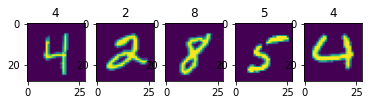

In [ ]:
print('Training data shapes: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Testing data shapes: X=%s, y=%s' % (x_test.shape, y_test.shape))
for j in range(5):
    i = np.random.randint(0, 100)
    plt.subplot(350 + 1 + j)
    plt.imshow(x_train[i],)
    plt.title(y_train[i])
plt.show()


In [ ]:
### Train the model on the images from the training set until the losses
### converge.
### Use "history = model.fit" to store the training and validation losses in
### a dictionary so you can plot them later.


history = vae.fit(x_train, y_train, epochs=100, batch_size=64,
                    validation_data=(x_test, y_test))

tr_data = x_train.astype('float32')/255
tst_data = x_test.astype('float32')/255
tr_data = np.reshape(tr_data, (60000, 28, 28, 1))
tst_data = np.reshape(tst_data, (10000, 28, 28, 1))
print (tr_data.shape, tst_data.shape)

Epoch 1/100
Tensor("IteratorGetNext:1", shape=(None,), dtype=uint8) Tensor("vae/decoder/reshape/Reshape:0", shape=(None, 28, 28, 1), dtype=float32)
Tensor("IteratorGetNext:1", shape=(None,), dtype=uint8) Tensor("vae/decoder/reshape/Reshape:0", shape=(None, 28, 28, 1), dtype=float32)
938/938 [==============================] - 17s 13ms/step - loss: -1461.2916 - kl_metric: 4.1236 - val_loss: -1470.2581 - val_kl_metric: 4.1473e-04
Epoch 2/100
938/938 [==============================] - 11s 12ms/step - loss: -1474.7546 - kl_metric: 2.9629e-04 - val_loss: -1470.2582 - val_kl_metric: 2.2080e-04
Epoch 3/100
938/938 [==============================] - 12s 12ms/step - loss: -1474.7544 - kl_metric: 1.8384e-04 - val_loss: -1470.2582 - val_kl_metric: 1.5850e-04
Epoch 4/100
938/938 [==============================] - 11s 12ms/step - loss: -1474.7562 - kl_metric: 1.3525e-04 - val_loss: -1470.2582 - val_kl_metric: 1.3295e-04
Epoch 5/100
938/938 [==============================] - 11s 12ms/step - loss: -14

{'loss': [-1461.2916259765625, -1474.754638671875, -1474.75439453125, -1474.7562255859375, -1474.7557373046875, -1474.7567138671875, -1474.7559814453125, -1474.75537109375, -1474.7567138671875, -1474.756591796875, -1474.755859375, -1474.7557373046875, -1474.7554931640625, -1474.7548828125, -1474.7562255859375, -1474.754638671875, -1474.75634765625, -1474.7559814453125, -1474.755615234375, -1474.7554931640625, -1474.755615234375, -1474.7548828125, -1474.755615234375, -1474.756591796875, -1474.7554931640625, -1474.7552490234375, -1474.754638671875, -1474.7552490234375, -1474.756103515625, -1474.7559814453125, -1474.7552490234375, -1474.755859375, -1474.7572021484375, -1474.7559814453125, -1474.75634765625, -1474.7554931640625, -1474.7552490234375, -1474.755859375, -1474.7552490234375, -1474.7557373046875, -1474.7535400390625, -1474.75634765625, -1474.7547607421875, -1474.75537109375, -1474.755615234375, -1474.755126953125, -1474.75537109375, -1474.7559814453125, -1474.755859375, -1474.75

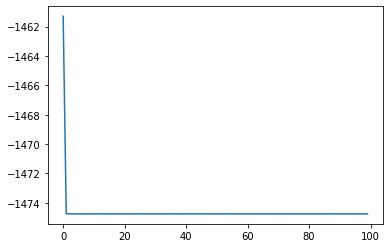

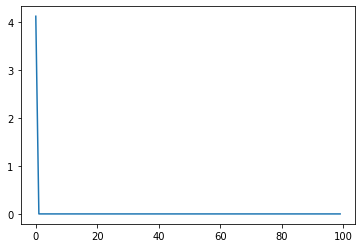

In [ ]:
print(history.history)
print(history.history.keys())

plt.plot(history.history['loss'])
plt.show()

plt.plot(history.history['kl_metric'])
plt.show()

Real Test Images


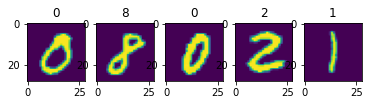

Images after reconstruction using Variational Autoencoder


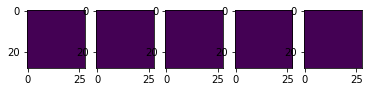

In [18]:
offset=400
print ("Real Test Images")
# Real Images
for j in range(5):
    i = np.random.randint(0, 100)
    plt.subplot(350 + 1 + j)
    plt.imshow(x_train[i])
    plt.title(y_train[i])
plt.show()
# images after reconstruction
print ("Images after reconstruction using Variational Autoencoder")

for i in range(5):
    plt.subplot(350 + 1 + i)
    output = vae.predict(np.array([tst_data[i+offset]]))
    output_image = np.reshape(output[0]*255, (28, 28))
    plt.imshow(output_image)
plt.show()
